# How does training with weight affect the results?

To understand this we need to look at a few things:

- Training with weighting turned on and off
- Evaluating with weight turned on and off

And there are two different weights we have to look at:

- multijet cross section weight per sample.
- Flatten by pT weight

To really do this right, we need to explore all of this.

## Initalization

In [1]:
import bdt_training_scikit_tools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from math import sqrt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## Load data samples
Load up the following:

- Job 8: Standard weights, with flat in pT

In [2]:
flat_samples = bdt_training_scikit_tools.load_default_samples("8")

BIB length: 156359
Multijet length: 1499995
Signal length: 1322937


## Training with the Flattened Weighted Sample

In [3]:
flat_training, flat_testing = bdt_training_scikit_tools.test_train_samples(flat_samples)

In [4]:
def train_samples (samples, use_weight = False):
    '''Train samples with various options
    
    Args:
        samples - the list bib, mj, and signal samples for training
        use_weight - if true, then do a weighted training
    '''
    all_events, all_events_class, weights = bdt_training_scikit_tools.prep_samples(samples[0], samples[1], samples[2])
    
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(min_samples_leaf=0.01),
        n_estimators=10,
        learning_rate=1)
    
    if not use_weight:
        weights = None
    
    bdt.fit(all_events, all_events_class.Class, sample_weight=weights)
    
    # The BDT is sent back for use
    return bdt

In [5]:
%%time
b_flat_weighted = train_samples(flat_training, use_weight=True)

Wall time: 18min 40s


In [41]:
def plot_training_performance (bdt, training_sample, testing_sample, title_keyword):
    '''Generate a figure that shows training as a function of the number of trees and some quick info
    on the differences between test and training samples.
    
    Args
        bdt - the BDT we are testing
        training_sample - the tripple of training samples (bib, mj, hss)
        testing_sample - the tripple of testing samples
        
    Returns
        fig - a figure
    '''

    # Extract test and training events suitable to feeding to the bdt
    test_events, test_events_class, test_weights = bdt_training_scikit_tools.prep_samples(testing_sample[0], testing_sample[1], testing_sample[2])
    train_events, train_events_class, training_weights = bdt_training_scikit_tools.prep_samples(training_sample[0], training_sample[1], training_sample[2])

    # Training performance looks at generic things - like has the tree settled down quickly or not.
    test_errors = []
    for test_predict in bdt.staged_predict(test_events):
        test_errors.append(1.0 - accuracy_score(test_predict, test_events_class.Class))

    n_trees = len(bdt)
    estimator_errors = bdt.estimator_errors_[:n_trees]

    # Compare training and testing prediction vs what we see.
    test_predictions = bdt.predict(test_events)
    train_predictions = bdt.predict(train_events)
    
    # Generate the figure to return
    fig = plt.figure(figsize=(15,15))

    ax = plt.subplot(221)
    ax.plot(range(1, n_trees+1), test_errors, c='black')
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel('Test Error')
    ax.set_xlabel('Number of trees')
    ax.set_title('Test Error for {0} training'.format(title_keyword))

    ax = plt.subplot(222)
    ax.plot(range(1,n_trees+1), estimator_errors, c='black', label="SAMME")
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('Esitmator Error')
    ax.set_xlabel('Number of trees')
    ax.set_title('Estimator Error for {0} training'.format(title_keyword))

    ax = plt.subplot(223)
    ax.hist([test_events_class.Class, test_predictions], label=["Actual", "Predicted by BDT"], bins=[0,1,2,3])
    ax.set_xticks([0.5,1.5,2.5])
    ax.set_xticklabels(['BIB', 'MJ', 'HSS'])
    ax.set_title('Test Events: Prediction vs Actual for {0} training'.format(title_keyword))
    ax.legend()

    ax = plt.subplot(224)
    ax.hist([train_events_class.Class, train_predictions], label=["Actual", "Predicted by BDT"], bins=[0,1,2,3])
    ax.set_xticks([0.5,1.5,2.5])
    ax.set_xticklabels(['BIB', 'MJ', 'HSS'])
    ax.set_title('Train Events: Prediction vs Actual for {0} training'.format(title_keyword))
    ax.legend()

    return fig

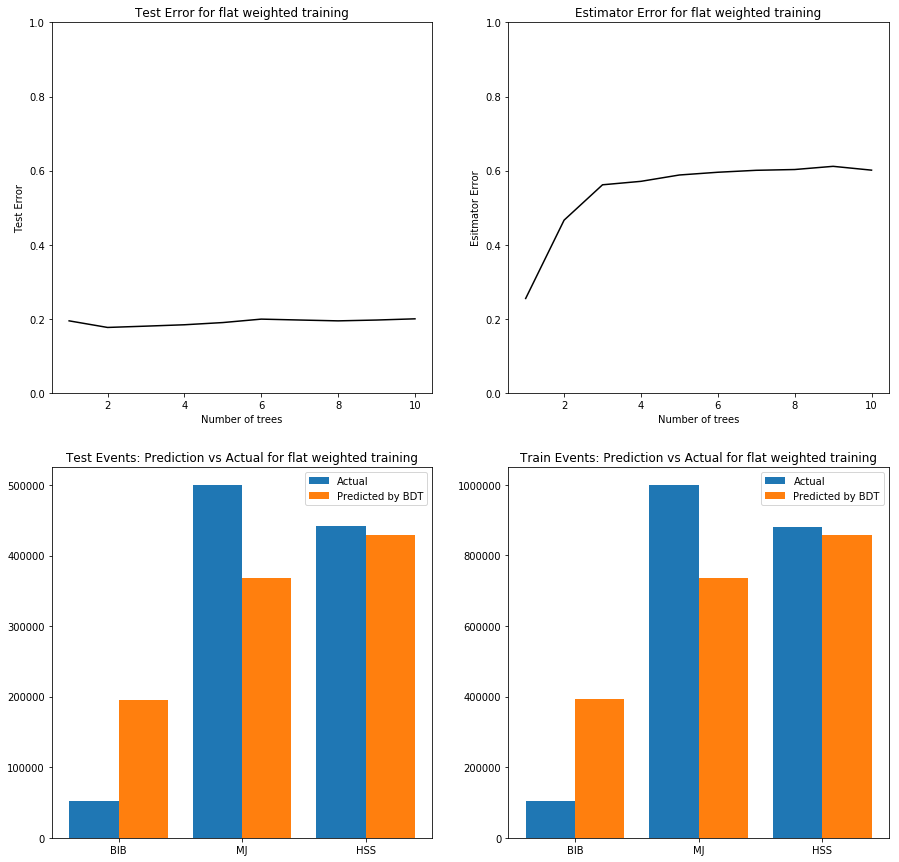

In [46]:
plot_training_performance(b_flat_weight, flat_training, flat_testing, title_keyword='flat weighted')

In [7]:
%%time
b_flat_unweighted = train_samples(flat_training, use_weight=False)

Wall time: 17min 10s


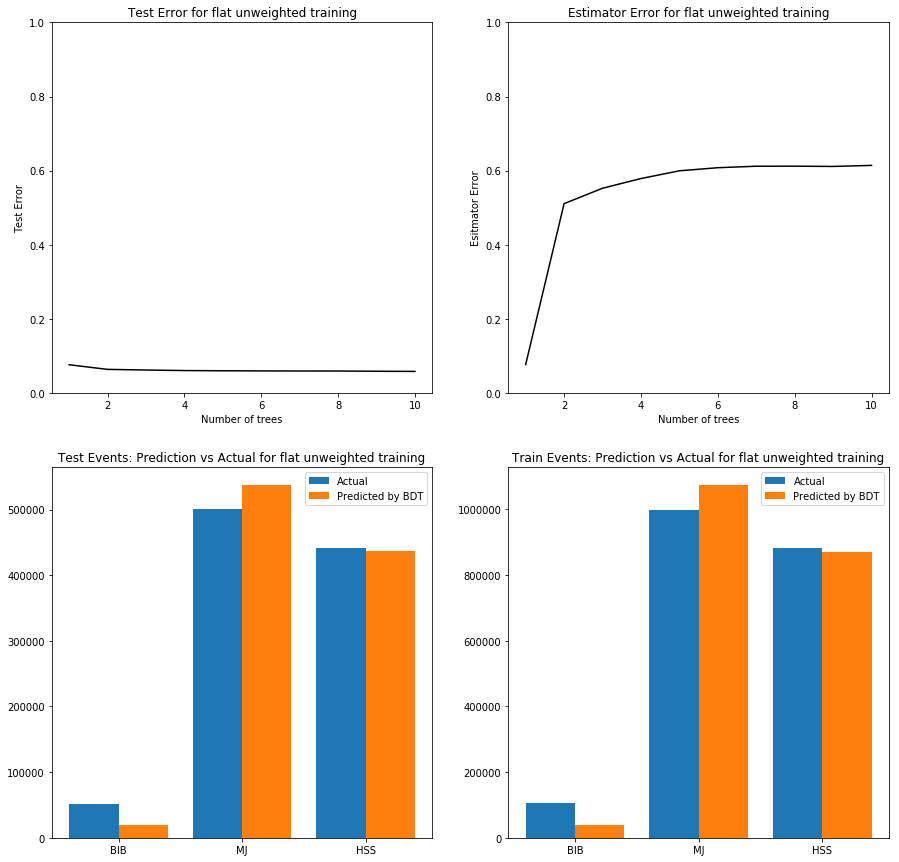

In [47]:
plot_training_performance(b_flat_unweighted, flat_training, flat_testing, title_keyword='flat unweighted')

## Understanding the signal to sqrt background
Calculate the S/sqrt(B) for all the trainings. Note that we always do this calculation with weighted events.

In [98]:
def calc_performance (bdt, testing_samples):
    '''Calculate the nubers in each class, as well as S/sqrt(B) for HSS
    
    All sums are done with event weights taken into account
    
    Args
        bdt - The BDT trained
        testing_samples - tripple (bib, mj, signal) of events that this wasn't trained on
        
    Return
        d - dict containing number of events of each type predicted for each time, and S/sqrt(B) for S as signal and B as mj+bib
    '''
    
    test_events, test_events_class, test_weights = bdt_training_scikit_tools.prep_samples(testing_samples[0], testing_samples[1], testing_samples[2])
    test_predictions = bdt.predict(test_events)
    
    # Assemble a single DataFrame with all the information we are going to need
    df = pd.DataFrame(test_predictions, columns=['PredClass'])
    df.loc[:,'Class'] = test_events_class
    df.loc[:,'Weight'] = test_weights
    
    # Next, for each sample, calculate what we need.
    class_events = [df.Class == index for index in (0,1,2)]
    pred_events = [df.PredClass == index for index in (0,1,2)]        
    labels = {0:'BIB', 1:'MJ', 2:'HSS'}
    
    d = {"{0}in{1}".format(labels[aclass], labels[pclass]):np.sum((class_events[aclass]&pred_events[pclass])*test_weights) for pclass in (0,1,2) for aclass in (0,1,2)}
    
    # Calculated quantities
    
    d.update({'{0}Eff'.format(labels[aclass]):np.sum((pred_events[aclass]&class_events[aclass])*test_weights)/np.sum(class_events[aclass]*test_weights) for aclass in (0,1,2)})
    d.update({'{0}Back'.format(labels[aclass]):np.sum((pred_events[aclass]&(~class_events[aclass]))*test_weights) for aclass in (0,1,2)})
    d.update({'{0}SsqrtB'.format(labels[aclass]):(d['{0}in{0}'.format(labels[aclass])]/sqrt(d['{0}Back'.format(labels[aclass])])) for aclass in (0,1,2)})
    
    return d

In [101]:
flat_unweighted_info = calc_performance(b_flat_unweighted, flat_testing)
flat_weighted_info = calc_performance(b_flat_weight, flat_testing)

info = pd.DataFrame({'flat_unweighted':flat_unweighted_info, 'flat_weighted':flat_weighted_info})
info

,flat_unweighted,flat_weighted
BIBBack,0.280364,9.127997
BIBEff,0.207570,0.565826
BIBSsqrtB,13.355351,6.380383
BIBinBIB,7.071575,19.276781
BIBinHSS,1.393365,0.990521
BIBinMJ,25.603424,13.801062
HSSBack,1.755732,1.416399
HSSEff,0.960054,0.940474
HSSSsqrtB,24.667766,26.904041
HSSinBIB,0.131505,1.468970


In [63]:
mtest_events, mtest_events_class, mtest_weights = bdt_training_scikit_tools.prep_samples(flat_testing[0], flat_testing[1], flat_testing[2])


In [95]:
class_bib = mtest_events_class.Class == 0
class_mj = mtest_events_class.Class == 1
np.sum((class_bib&class_bib)*mtest_weights)

34.068363682643394